In [1179]:
import numpy as np
from numpy import rot90
from numpy.fft import fft2, ifft2

import PIL as pillow
from PIL import Image, ImageFile

import cv2
import os
import random
from math import ceil
from matplotlib import pyplot as plt
from copy import deepcopy
from Levenshtein import distance as levenshtein_distance

# For some reason all my files are "corrupted" and it won't work without this magic line :)
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [1180]:
def plot_image(image, title = "", colormap = "gray") :
    plt.figure(figsize=(10, 10))
    plt.plot()
    plt.imshow(image, cmap = colormap)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [1181]:
def simmilarity(a, b) :
    lev_dist = levenshtein_distance(a, b)

    max_len = max(len(a), len(b))

    return 1 - lev_dist / max_len

In [1182]:
invert_colors = lambda x : cv2.bitwise_not(x)

def to_grayscale(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return grayscale

def from_grayscale(image):
    image_array = np.asarray(image)
    return np.array([[(val, val, val) for val in row] for row in image_array])


def scale_image(image, factor):
    return image.resize(np.array(image.size) * factor)

In [1183]:

SCRIPT_PATH = os.getcwd()
TEXTS_DIRECTORY = os.path.join(SCRIPT_PATH, "texts")
CHARACTERS_DIRECTORY = os.path.join(SCRIPT_PATH, "fonts/alphabets")

LATIN_LETTERS = [str(i) for i in range(10)] + [chr(i) for i in range(ord("a"), ord("z") + 1)] + [".", ",", "?", "!", " "]


class Character:
    def __init__(self, char, path, color=None):
        self.char = char
        self.image = invert_colors(to_grayscale(image=cv2.imread(path)))
        self.color = (
            color if color is not None else [0 for _ in range(3)]
        )

    def display(self):
        plot_image(self.image)


def initialize_characters(font_name, chars=LATIN_LETTERS):
    characters = {}
    space = None
    for char in chars:
        text = char
        if char == "." : char = "dot"
        elif char == "," : char = "comma"
        elif char == "?" : char = "question"
        elif char == "!" : char = "exclamation"
        elif char == " " : 
            char = "space"
            space = Character(char=text, path=os.path.join(CHARACTERS_DIRECTORY, font_name + "_alphabet", filename))
            continue
        filename = char + ".png"
        characters[text] = Character(char=text, path=os.path.join(CHARACTERS_DIRECTORY, font_name + "_alphabet", filename))
    return characters, space


def show_characters(characters, additionals, items_in_row=7):
    fig = plt.figure(figsize=(10, 7))
    rows_num, columns_num = ceil((len(characters) + len(additionals)) / items_in_row), items_in_row
    j = 0
    for i, character_key in enumerate(characters):
        fig.add_subplot(rows_num, columns_num, i + 1)
        plt.imshow(from_grayscale(characters[character_key].image))
        plt.axis("off")
        j = i
    for additional in additionals:
        fig.add_subplot(rows_num, columns_num, j + 1)
        plt.imshow(from_grayscale(additional.image))
        plt.axis("off")
        j += 1
        
def find_data(filenumber) :
    
    filename = None
    check_name = None
    font_name = None

    filenumber_str = str(filenumber)

    for file in os.listdir(TEXTS_DIRECTORY) :
        filetable = file.split("_")
        if filetable[0] == filenumber_str :
            font_name = filetable[2]
            if filetable[1] == "image" :
                filename = file
                if check_name is not None : break
            elif filetable[1] == "text" :
                check_name = file
                if filename is not None : break
    
    
    with open(os.path.join(TEXTS_DIRECTORY, check_name), 'r') as f:
        text_content = f.read()
                
    return filename, text_content, font_name

filename, check, font_name = find_data(1)


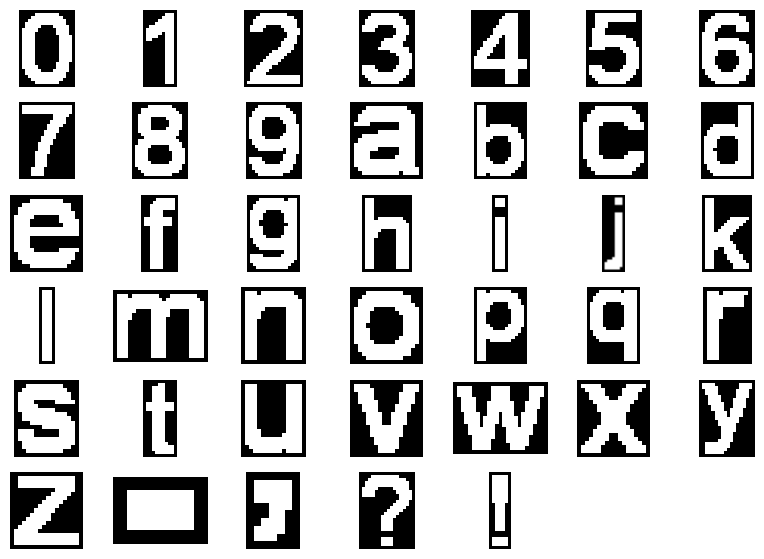

In [1184]:
font_characters, space = initialize_characters(font_name)

show_characters(font_characters, [space])

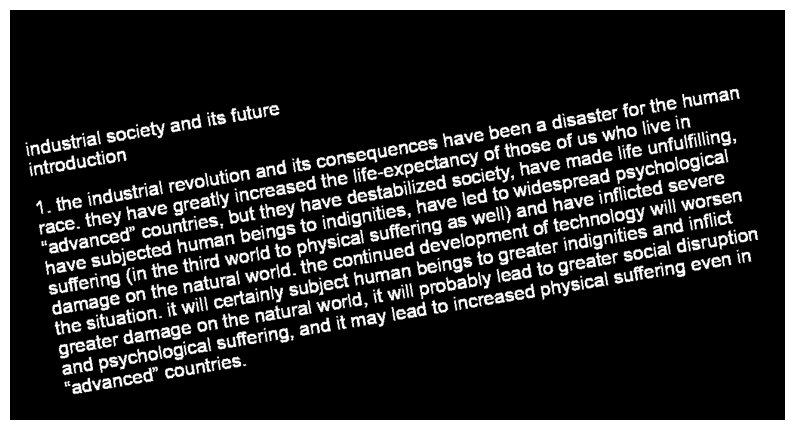

In [1185]:
image = invert_colors(to_grayscale(image=cv2.imread(os.path.join(TEXTS_DIRECTORY, filename))))
plot_image(image)

In [1186]:

load_image = lambda x : cv2.imread(os.path.join(SCRIPT_PATH,"texts",x))

In [1187]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Oblicz nowy rozmiar obrazu, aby zmieścił się po obrocie
    cos = np.abs(np.cos(angle))
    sin = np.abs(np.sin(angle))
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    
    # Przesunięcie do centrum nowego rozmiaru obrazu
    M = cv2.getRotationMatrix2D(center, angle * 180 / np.pi, 1.0)
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
    
    # Użyj interpolacji najbliższego sąsiada
    rotated = cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
    return rotated

In [1188]:
def blacked(image_array):
    # Tworzymy maskę, która identyfikuje wszystkie elementy różne od (255, 255, 255)
    mask = np.any(image_array != [255, 255, 255], axis=-1)
    # Ustawiamy elementy różne od (255, 255, 255) na (0, 0, 0)
    image_array[mask] = [0, 0, 0]
    return image_array

In [1189]:
def cut_image(image) :
    image_array = np.array(image)
    # Przyjmijmy, że image_array to zwracana tablica NumPy z funkcji create_text_image()

    # Znajdź indeksy niebiałych pikseli w każdym wymiarze
    non_white_cols = np.any(np.any(image_array != [255, 255, 255], axis=-1), axis=1)
    # Znajdź indeksy kolumn zawierające niebiałe piksele
    non_white_rows = np.any(np.any(image_array != [255, 255, 255], axis=-1), axis=0)

    minimal_row = float('inf')
    maximal_row = float('-inf')
    minimal_col = float('inf')
    maximal_col = float('-inf')

    for i in range(len(non_white_rows)) :
        val = non_white_rows[i]
        if val :
            minimal_row = min(minimal_row, i)
            maximal_row = max(maximal_row, i + 1)
    for i in range(len(non_white_cols)) :
        val = non_white_cols[i]
        if val :
            minimal_col = min(minimal_col, i)
            maximal_col = max(maximal_col, i + 1)
    
    x_range = maximal_row - minimal_row
    y_range = maximal_col - minimal_col
    
    new_image_array = np.zeros((y_range, x_range, 3))
    
    for x in range(x_range) :
        for y in range(y_range) :
            new_image_array[y,x] = image_array[minimal_col + y, minimal_row + x]
    
    return blacked(new_image_array)

-0.1610749838808208


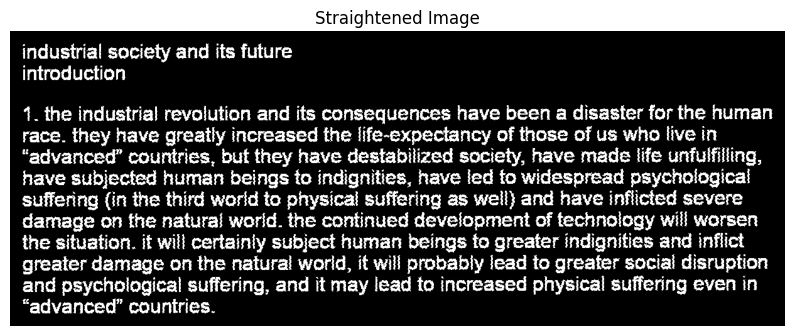

In [1190]:
import cv2
import numpy as np

def add_margins(image, margin):
    h, w = image.shape[:2]
    new_image = np.full((h + 2 * margin, w + 2 * margin, 3), 255, dtype=np.uint8)
    new_image[margin:margin+h, margin:margin+w] = image
    return new_image

def denoise_image(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)


def straighten_image(image):
    # Wykrywanie krawędzi za pomocą algorytmu Canny'ego
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    
    # Wykrywanie linii za pomocą transformacji Hougha
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    
    # Obliczenie średniego kąta nachylenia linii
    angles = []
    if lines is not None:
        for rho, theta in lines[:, 0]:
            angles.append(theta - np.pi / 2)
    
    # Obliczenie średniego kąta nachylenia
    if angles:
        mean_angle = np.mean(angles)
    else:
        mean_angle = 0
    
    print(mean_angle)
    
    # Obrót obrazu o obliczony kąt
    straightened_image = denoise_image(add_margins(cut_image(rotate_image(image, mean_angle)), 20))
    
    
    return straightened_image

# Przykład użycia

image = load_image(filename)

image = invert_colors(to_grayscale(straighten_image(image)))

# Wyświetlanie wyprostowanego obrazu
plot_image(image, "Straightened Image")


In [1191]:
def calculate_correlation(whole_image, searched_image, normalize=True):
    def rot180(arr):
        return rot90(rot90(arr))

    image_width, image_height = whole_image.shape

    fft2_whole_image = fft2(whole_image)
    rot180_searched_image = rot180(searched_image)
    fft2_searched_image = fft2(rot180_searched_image)
    
    result = ifft2(
        fft2_whole_image * fft2(rot180_searched_image, s=(image_width, image_height))
    ).real
    if normalize:
        val = np.abs(np.max(result))
        if val == 0 : 
            plot_image(searched_image)
        result /= val
    return result

In [1192]:
def calculate_all_characters_correlations(characters, whole_image, normalize_each=False):
    for character_key in characters:
        character = characters[character_key]
        character.correlation = calculate_correlation(
            whole_image=whole_image,
            searched_image=character.image,
            normalize=not normalize_each,
        )
        if normalize_each:
            self_correlation = np.max(
                calculate_correlation(
                    whole_image=character.image,
                    searched_image=character.image,
                    normalize=False,
                )
            )
            character.correlation /= self_correlation

In [1193]:
def mark_found_elements(image_arr, correlation, certainty, selection_size, color):
    found_locations = []
    for y in range(correlation.shape[0]):
        for x in range(correlation.shape[1]):
            if correlation[y, x] > certainty:
                found_locations.append((y, x))

    result = image_arr.copy()
    for y, x in found_locations:
        for dy in range(0, selection_size[0], np.sign(selection_size[0])):
            for dx in range(0, selection_size[1], np.sign(selection_size[1])):
                result[y + dy, x + dx] = color
    return result


def mark_and_display_all_letters(characters, certainity=0.95):
    result = from_grayscale(image)
    for character_key in characters:
        if character_key == " " : continue
        # character = characters[character_key]
        result = mark_found_elements(
            image_arr=result,
            correlation=characters[character_key].correlation,
            certainty=certainity,
            selection_size=(4, -12),
            color=characters[character_key].color,
        )
    result = Image.fromarray(result)
    plot_image(result)

(469, 1234)


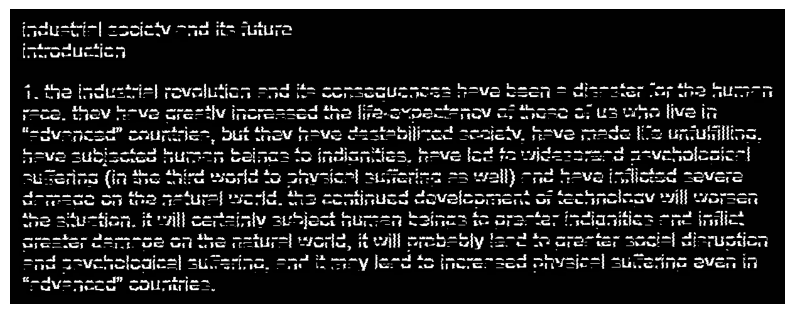

In [1194]:
print(image.shape)

calculate_all_characters_correlations(font_characters, whole_image=deepcopy(image))
mark_and_display_all_letters(font_characters, certainity=0.96)

In [1195]:
def get_all_char_locations(characters, certainity=0.95):
    locations = {}
    for character_key in characters:
        correlation = characters[character_key].correlation
        for y in range(correlation.shape[0]):
            for x in range(correlation.shape[1]):
                if correlation[y, x] > certainity:
                    if (y, x) not in locations or locations[(y, x)][1] < correlation[y, x]:
                        locations[(y, x)] = characters[character_key].char, correlation[y, x]

    found_characters = list(locations.items())
    found_characters.sort(key=lambda x: x[0][1])
    found_characters.sort(key=lambda x: x[0][0])
    return found_characters

In [1196]:
def char_locations_to_string(
    char_locations,
    image_height,
    image_width,
    x_radius,
    y_radius,
    whitespace_width,
    alpha,
):
    # Making one line truly one line
    letters_in_line = [0 for i in range(image_height)]
    for (y, _), _ in char_locations:
        letters_in_line[y] += 1
    lines_by_letters = [
        (i, num_of_letters) for i, num_of_letters in enumerate(letters_in_line)
    ]
    lines_by_letters.sort(key=lambda x: x[1], reverse=True)

    true_line = [i for i in range(image_height)]
    for y, _ in lines_by_letters:
        if true_line[y] != y or letters_in_line[y] < alpha * lines_by_letters[0][1]:
            continue
        for dy in range(-y_radius, y_radius + 1):
            if dy != 0 and 0 <= y + dy < image_height:
                letters_in_line[y] += letters_in_line[y + dy]
                letters_in_line[dy] = 0
                true_line[y + dy] = y

    old_locations = char_locations
    line_content = {}
    for (old_y, x), (char, score) in old_locations:
        y = true_line[old_y]
        new_record = (y, x), (char, score)
        if y not in line_content:
            line_content[y] = [new_record]
        else:
            line_content[y].append(new_record)

    # Remove multiple characters
    chars_by_line = []
    for y in sorted(list(line_content.keys())):
        # line_content[y].sort(key=lambda x: x[1])
        is_free = [True for _ in range(max(image_width, image_height))]
        letters_by_score = sorted(line_content[y], key=lambda x: x[1][1], reverse=True)
        remaining_letters = []
        for (y, x), char_score in letters_by_score:
            if is_free[x]:
                remaining_letters.append(((y, x), char_score))
                for dx in range(-x_radius, x_radius + 1):
                    if 0 <= x + dx < image_width:
                        is_free[x + dx] = False
        chars_by_line.append(sorted(remaining_letters, key=lambda x: x[0][1]))

    result = ""
    for line in chars_by_line:
        prev_x = None
        for (_, x), (char, _) in line:
            if prev_x is not None:
                result += " " * (round((x - prev_x) / whitespace_width) - 1)
            result += char
            prev_x = x
        result += "\n"
    return result

In [1197]:
char_locations = get_all_char_locations(font_characters, certainity=0.9)

txt = char_locations_to_string(
    char_locations,
    image_height=image.shape[1],
    image_width=image.shape[0],
    x_radius=5,
    y_radius=15,
    whitespace_width=11,
    alpha=0.3,
)
print(txt)
print()
print(check)
print()
print(simmilarity(txt, check))

.
.
.
i,r.c..,..i.,l ......i..... ...n..i..si.u..u..e
.
.   .   .
......  .. ...
.......  ... ...
..,.....   , ..
. ,  . .   , ..
,   ,   , .,
, ,,  ,   ,  ,
,,,,  ,   ,  ,
,,,,  ,   ,
,     ,
, , ,   ,
, , ,   ,
, . . .. ,
. .... .... .
i n. . .8....i.o n
i ntr.o.i.u.cli.o n
i nl   l u l
l   4
4
? ?     ?
1. ..h.. i.,........i..l ......l...i.,.. .....ii.,,.,..!!,,,........,.............,.......................,,..,,.s,.,..,,.....................................c..............................c.....o,,,...o,,,,,..,..,,...,.......r...nn,..........................................,..,....s,.,.,..,,.........................,..c,.e,,,...,,............................,....,,o,..............u...,,.,.,,.........................e,.,..,,..........rr.....nn,..,,...........x......................c..c,,,,...,.,,..........................e.........,,.............................,.,.s...iii,..,,........r.....h..hh,,,,..,...,..,....,.........................................,,,..,,...,.....,a...,,,z....

In [1198]:
def read_text(filenumber, x_radius=5, y_radius=28, whitespace_width=11, alpha=0.3, certainity=0.95, normalize_each=False, display_image=True):
    
    filename, check, font_name = find_data(filenumber)
    
    characters, space = initialize_characters(font_name)
    
    
    text_photo = invert_colors(to_grayscale(straighten_image(cv2.imread(os.path.join(TEXTS_DIRECTORY, filename)))))
    if display_image:
        plot_image(text_photo)

    calculate_all_characters_correlations(
        characters, whole_image=text_photo, normalize_each=normalize_each
    )
    char_locations = get_all_char_locations(characters, certainity)

    text = char_locations_to_string(
        char_locations,
        image_height=text_photo.shape[0],
        image_width=text_photo.shape[1],
        x_radius=x_radius,
        y_radius=y_radius,
        alpha=alpha,
        whitespace_width=whitespace_width,
    )
    
    print(text)
    
    print("=====")
    
    print(check)
    
    print("=====")
    
    print(round(simmilarity(text, check) * 100, 2), "%")
    

-0.04489431943835211


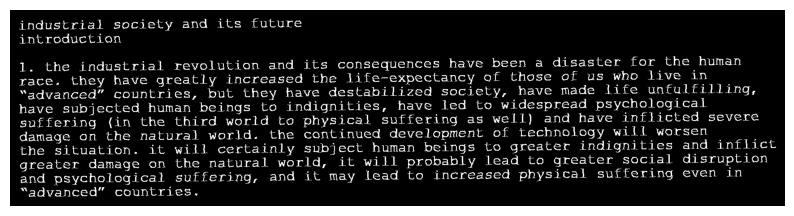

.u    .                          !         f u    . e
5
1.   t.    .    d u.   . i a  . . e v  l       .       !     .   c o      q u z.     s  .h a      b           !        t  .4  f o.r   .h e   h u
5           7  6   u    3    a.   5       .   7  .  5               5    . z   3  s    7     y.  .      .     d        .h o l o      a         ?.
.          u    e      3   h u        b e i    s          n d        t    s,   n a      l  3           !    p          p             g
v e  .    j           .6     .6  . 5    g.             4 8           s   f f  .              w         a      n   v        f l i      3         .
.   f        0    .5           .         .   3     .                  .    k    .   2 g                     .     9 7  .        e s.   n
. u a  i    .   i     .  l         .          .      j e c      u m a n.        g         3         .   a t e.r g    c i a l   3 i  .       i
.   a        dka         o      5          u r      w  r  !,   i t  .     l   p      a b     

In [1199]:
txt = read_text(filenumber = 0)